<a href="https://colab.research.google.com/github/erichsiao1106/cnn/blob/master/lymphoma_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [ ]:
IMG_SIZE = 200
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

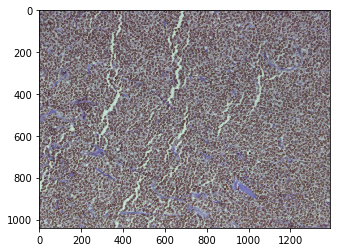

In [ ]:
# Read single image
data_path = 'drive/My Drive/北分署/week8/lymphoma/*/*.tif' 
img_paths = glob(data_path)
img_paths = np.random.choice(img_paths, 50) # demo for 200 images
img = cv2.imread(img_paths[0])
plt.imshow(img)

((1040, 1388, 3), (200, 200, 3))

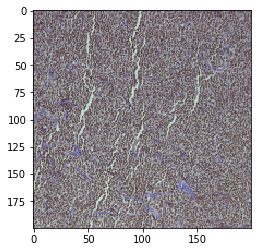

In [ ]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/class/緯育醫學影像/Day4/lymphoma/MCL/sj-05-3362-R2_014.tif'

In [ ]:
cls = img_path.split('/')[-2]
cls

'MCL'

In [ ]:
class_map[cls]

1

In [ ]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [ ]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [ ]:
# label count
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 12, 1.0: 20, 2.0: 18}

In [ ]:
X = X/255
y_onehot = keras.utils.to_categorical(y, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 200, 200, 3), (10, 200, 200, 3), (40, 3), (10, 3))

In [ ]:
# 1
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation=keras.activations.relu)(x)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

W0905 12:08:42.872066 139721771505536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 12:08:42.912436 139721771505536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 12:08:42.921984 139721771505536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 12:08:42.960359 139721771505536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 94, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 16)        0   

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

W0905 12:08:43.050305 139721771505536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0905 12:08:43.057922 139721771505536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


In [ ]:

logs = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                verbose=1,
                callbacks=[early_stopping, checkpoint, reduce_lr],     
                validation_data=(X_test, y_test))

W0905 12:08:43.176417 139721771505536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0905 12:08:43.236988 139721771505536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 40 samples, validate on 10 samples
Epoch 1/100
40/40 [==============================] - 9s 217ms/step - loss: 1.3423 - acc: 0.2000 - val_loss: 1.0414 - val_acc: 0.4000
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 1.0569 - acc: 0.3500 - val_loss: 1.1128 - val_acc: 0.4000
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 1.1039 - acc: 0.4750 - val_loss: 1.0919 - val_acc: 0.4000
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 1.0872 - acc: 0.3500 - val_loss: 1.0765 - val_acc: 0.4000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 1.0567 - acc: 0.3500 - val_loss: 1.0760 - val_acc: 0.4000
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 1.0532 - acc: 0.3500 - val_loss: 1.0764 - val_acc: 0.4000
Epoch 00006: early stopping


In [ ]:
history = logs.history

In [ ]:
model.save_weights('`.h5')

Text(0.5, 1.0, 'acc')

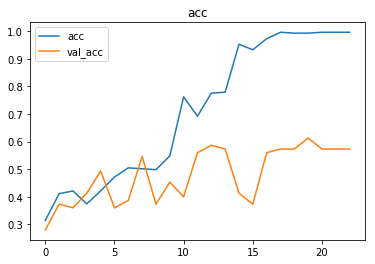

In [ ]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

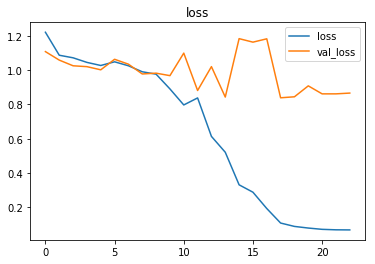

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(3)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


(75,) (75,)
              precision    recall  f1-score   support

           0       0.48      0.74      0.58        19
           1       0.53      0.31      0.39        29
           2       0.69      0.74      0.71        27

    accuracy                           0.57        75
   macro avg       0.57      0.60      0.56        75
weighted avg       0.58      0.57      0.56        75

[[14  4  1]
 [12  9  8]
 [ 3  4 20]]
